In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install() # expect a kernel restart

In [ ]:
%%capture
! mamba search openmc
! yes|mamba install openmc -y > /dev/null 2>&1

In [ ]:
# Correct the Box link to direct download format
!wget -O endfb-viii.0-hdf5.tar "https://uofi.box.com/shared/static/od5zy3e3tckd7hpds7yngy9ux1nlir4d"

# Extract the tar file
!tar -xf /content/endfb-viii.0-hdf5.tar -C /content/

# Check if the XML file exists
import os
if not os.path.isfile("/content/endfb-viii.0-hdf5/cross_sections.xml"):
    raise ValueError("Installation of cross sections was not completed!")
else:
    print("Installation completed")

# Display the first 10 lines of the XML file
!cat "/content/endfb-viii.0-hdf5/cross_sections.xml" | head -10

# Set the environment variable for OpenMC
os.environ['OPENMC_CROSS_SECTIONS'] = "/content/endfb-viii.0-hdf5/cross_sections.xml"

# Modeling a Pincell
In this module, we'll demonstrate the basic features of the Python API for constructing input files and running OpenMC. In it, we will show how to create a basic reflective pincell model that is equivalent to modeling an infinite array of fuel pins in a pressurized water reactor.


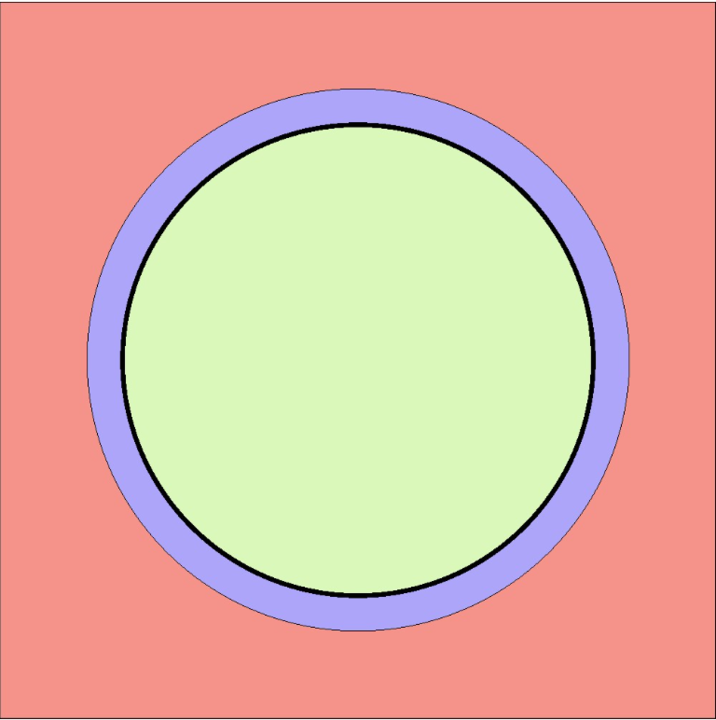

For this example, we'll create a simple pincell that is composed of:
- UO<sub>2</sub> with 3.5 weight% enriched in U-235 at 11 g/cm<sup>3</sup>
- zirconium clad at 6.5 g/cm<sup>3</sup>
- H<sub>2</sub>O moderator at 1.0 g/cm<sup>3</sup>

The dimensions of our fuel pin will be as follows:
- Fuel outer radius = 0.46955 cm
- Clad inner radius = 0.47910 cm
- Clad outer radius = 0.54640 cm
- Fuel pin pitch = 1.44270 cm

Useful web pages we will visit, and which are good to have bookmarked when developing OpenMC models:

- [Python API documentation](https://docs.openmc.org/en/stable/pythonapi/index.html)
- [pre-generated cross section libraries](https://openmc.org/)
- [user forum](https://openmc.discourse.group/)

## Modules

## Model

## Materials

### Zirconium

### Uranium Dioxide

### Water

### Registering

## Geometry

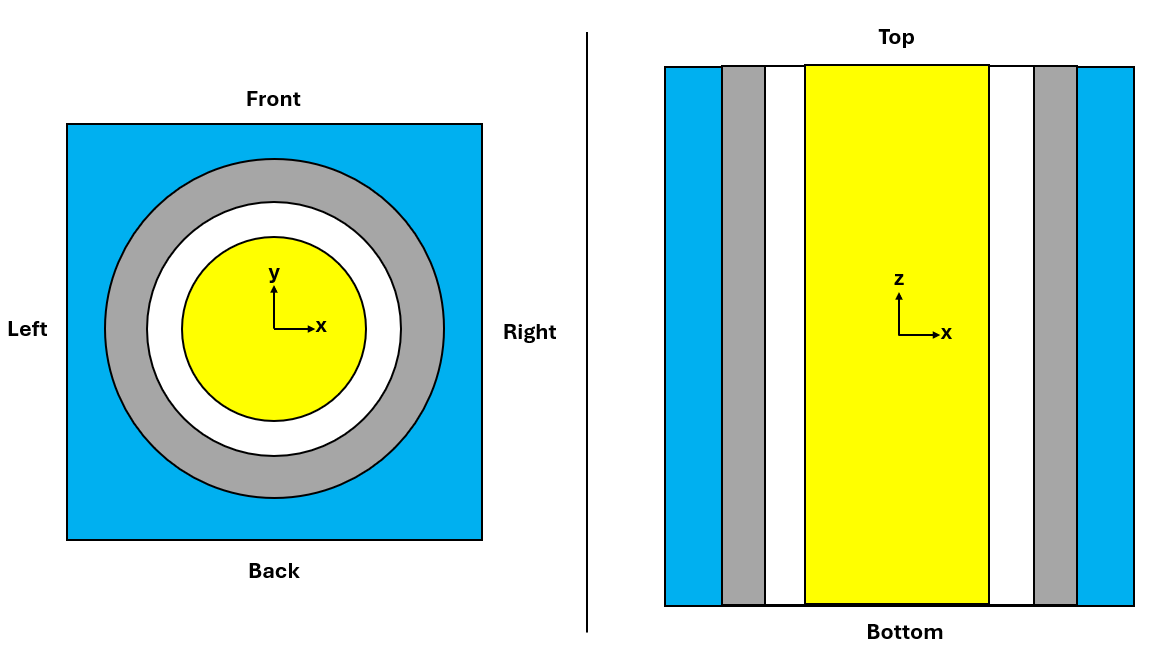

### Parameters

In [100]:
r_f    = 0.46955 
r_g    = 0.47910 
r_c    = 0.54640 
pitch  = 1.44270 
height = 300

### Surfaces

### Cells

### Boundary Conditions

### Registering

### Plotting

In [2]:
colors = {}

## Settings

### Source 

### Execution Parameters

### Registering

## Execution

# OpenMC Tallies

In this tutorial, we will learn how to:

  - Understand application of filters and scores to create tallies
  - Apply tallies to an OpenMC simulation
  - Extract information from OpenMC statepoint files
  - Understand tally units and normalization
  - Plot tally results

In this section, we'll be looking at how to extract custom information from an OpenMC simulation in what is known as a "tally." A tally accumulates statistical information during the simulation about particles when they eneter regions of phase space specified on the tally. The limits of these regions are set by "filters" applied to the tally. Scores and nuclides can also be applied to tallies to indicate what type of information is kept about the particle (e.g. reaction types, flux, heat, etc.).

Any tally in OpenMC can be described with the following form:

$$ 
 X = \underbrace{\int d\mathbf{r} \int d\mathbf{\Omega} \int
    dE}_{\text{filters}} \underbrace{f(\mathbf{r}, \mathbf{\Omega},
    E)}_{\text{scores}} \underbrace{\psi (\mathbf{r}, \mathbf{\Omega}, E)}_{\text{angular flux}}
$$

where filters set the limits of the integrals and the scoring function is convolved with particle information (e.g. reaction type, current material, etc.). For example, if you wanted to calculate the fission reaction rate caused by fast neutrons in cell 3, your tally becomes

$$ 
 X = \int_\text{cell 3} d\mathbf{r} \int_{4\pi} d\mathbf{\Omega} \int_{1 MeV}^{20 MeV}
    dE \ \ \Sigma_f(\mathbf{r}, \mathbf{\Omega},
    E) \psi (\mathbf{r}, \mathbf{\Omega}, E)
$$

<div class="alert alert-block alert-info">
A full list of scores and their meanings can be found <a href=https://docs.openmc.org/en/stable/usersguide/tallies.html#scores >here</a>.
</div>

In this exercise we'll be adding tallies to perform a few different tasks:


  **1. Compute the average energy released per fission** \
  **2. Plot the flux spectrum of the pincell** \
  **3. Plot the thermal and fast flux distributions of the pincell**


## Adding Tallies

### Energy Released Per Fission

To compute the energy released per fission, we will use two different scores -- the `kappa-fission` score, which tallies the recoverable energy release from fission, and the `fission` score, which tallies the fission rate. The energy released per fission, averaged over all fission events, is simply the `kappa-fission` score divided by the `fission` score.

Because we want this information talllied throughout the model, a "global" tally, no filters need to be applied.

### Flux Spectrum 

Plotting a neutron flux spectrum is a very useful way to understand the physical processes happening to neutrons - the energy at which they exist is determined by scattering reactions (to lower energies) as well as their birth distribution (such as from fission or fusion). It is often an engineer's objective to control the energies at which neutrons are predominantly at in their system in order to encourage reactions at different energy spectra.

To plot the neutron flux spectrum, we'll be applying a tally with an energy filter and a score. OpenMC's data module contains different group structures. For this problem we'll use the CASMO-70 group structure. An energy filter can easily be created from a pre-defined group structure in OpenMC as follows:

### Flux Distribution 

Bounding Box

Mesh

Filters

Tally

### Register Tallies

### Execution

In [ ]:
# model.settings.batches = 60
# model.settings.inactive = 10
# model.settings.particles = 5000

## Postprocessing 

If we list our current directory, we see that several new files have been created as a result of this run: `summary.h5`, `tallies.out`, and `statepoint.50.h5`. The summary file contains information about the simulation's setup (geometry, materials, meshes, etc.) in an HDF5 format. The `tallies.out` file contains a text output of all user-specified tallies for the simulation.

This can be useful to quickly look at simple tally results, but isn't a great format to post-process simulation data. For that we'll look to the statepoint file. The statepoint file contains information about simulation results including tally specifications and data. The location of this statepoint file was provided to us by the `model.run()` command.

### Modules

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat

### Extracting Tallies

To extract information from the statepoint file we'll create an `openmc.StatePoint` object. The `statepoint.get_tally` function will search for tallies by scores, filters, nuclides, ids, and return the closest match. Exact matches can be specified as well.

If we print the tally objects returned, we see that they indeed match the tally specification we generated above.

<div class="alert alert-block alert-info">
<b>A quick aside on how statepoint objects interact with summary files:</b>


The `openmc.statepoint` object will read information from the `summary.h5` file if one is present, keeping that file open in the Python interpreter. The open `summary.h5` file can interfere with the initialization of subsequent OpenMC simulations. It is recommended that information be extracted from statepoints within a [context manager](https://book.pythontips.com/en/latest/context_managers.html) as we do here. Alternatively, making sure to call the `openmc.StatePoint.close` method will work also. For more details please look to the [relevant section in the user's guide](https://docs.openmc.org/en/stable/usersguide/troubleshoot.html#runtimeerror-failed-to-open-hdf5-file-with-mode-w-summary-h5).   
</div>



### Energy Released Per Fission

To compute the energy released per fission event, we can simply take the tallied energy released per fission and divide it by the fission rate.

In [ ]:
#print(f"Average energy released per fission: {mev_per_fission:.1f} MeV")

For a water reactor with U235 as the only fissioning isotope this is about what we would expect: ~193 MeV! 

When dealing with tallies, we must remember that every output of a Monte Carlo simulation is uncertain -- it is associated with a mean and a standard deviation. Whenever you present results from a Monte Carlo simulation, you should ALWAYS present the mean value AND its standard deviation, or else your results are kind of meaningless (and you may be eviscerated!). To obtain the standard deviation associated with our MeV/fission estimation, we can use the Python [uncertainties](https://pythonhosted.org/uncertainties/) module, while also using the `value='std_dev'` option when fetching the tally values to get the standard deviations.

In [ ]:
#print(f'Average energy released per fission: {energy_per_fission:.1f}')

As with most values coming out of an MC code, these values are per source-particle. In this case these units cancel out, but this will not be the case in our next example.

### Flux Spectrum


Now to plot the spectrum, we will plot the neutron flux per unit lethargy (a common way to visualize neutron flux).

In [4]:
# unit_lethargy = spectrum_energy_filter.lethargy_bin_width
# spectrum = spectrum_tally_out.get_values(value='mean').flatten()
# plt.step(np.unique(spectrum_energy_filter.bins)[:-1], spectrum / unit_lethargy)
# plt.xscale('log')
# plt.xlabel('Energy (eV)')
# plt.ylabel('Flux per unit lethargy')
# plt.show()

### Normalizing Tallies

Note that the units of flux in the above plot are in $\frac{particle-cm}{source-particle}$. As is the case with many values tallied by Monte Carlo codes, the value of the flux does not account for volume and is in terms of the number of source particles emitted. To generate this same plot in terms of absolute flux units ($\frac{particle}{cm^{2}-s}$) we'll need to normalize this tally by:

  - the volume of the region the tally covers
  - the number of source particle emitted

In this case, the volume of the region is the volume of the entire pincell. Because we're working with a 2-D model, we'll get units that give us the flux per unit length of the pincell in the axial direction.OpenMC's geometry object allows for computation of a bounding box for geometries like this that will help make this more straight forward.

In order to obtain the volumes of the cells, we can use a stochastic volume calculation. Or, in this case, we can obtain the volumes from a bounding box of the geometry.

Determining the number of source particles per second is more complicated, however. This means computing the eV/source particle due to fission. To get the source rate, we'll need the following pieces of information:

  1. the total power produced in the tally region (known a priori)
  2. the heat produced by fission power, per source particle
  
 To get this information we'll need to construct another tally to get additional information from the simulation.

The combination of the following tally values and power provide us with the source normalization needed as follows:


$$ \text{neutron source} [\frac{n}{s}] = \text{power} [\frac{J}{s}] \times \frac{1}{1.6\times 10^{-19}} [\frac{eV}{J}] \times \frac{1}{\text{fission heat} [\frac{eV}{source}]} $$ 

In [6]:
J_to_eV = 1 / 1.6e-19
power = 200 # Watts

In [ ]:
#print(f'Neutron source: {neutron_source:.2e} n/s')

We can now use this information to normalize our flux values and reproduce our plot in more standard units.

In [7]:
# plt.step(np.unique(spectrum_energy_filter.bins)[:-1], normalized_spectrum / unit_lethargy)
# plt.xscale('log')
# plt.xlabel('Energy (eV)')
# plt.ylabel('Flux per unit lethargy')
# plt.show()

### Flux Distribution

Tally Shape

Dataframe

We will create a 2D numpy mesh matching our mesh in openmc

In [ ]:
# x_min = lower_left[0]
# x_max = upper_right[0]
# y_min = lower_left[1]
# y_max = upper_right[1]
# z_min = lower_left[2]
# z_max = upper_right[2]
# nx = 50
# ny = 50
# dx = (x_max - x_min)/nx
# dy = (y_max - y_min)/ny
# x = np.linspace(x_min+dx/2, x_max-dx/2, nx)
# y = np.linspace(y_min+dx/2, y_max-dx/2, ny)
# X, Y = np.meshgrid(x, y)

Compute the volume of each element in the mesh

Extract the thermal and the fast fluxes

Plot the thermal flux

In [8]:
# min_tf = np.min(normalized_thermal_flux)
# max_tf = np.max(normalized_thermal_flux)
# plt.pcolormesh(X, Y, normalized_thermal_flux, cmap = 'jet', vmin = min_tf, vmax = max_tf)
# plt.xlabel('x [cm]')
# plt.ylabel('y [cm]')
# plt.colorbar(norm=1.0, label="Thermal Flux ($n/cm^2 s$)", format='%.1e')

Plot the fast flux

In [9]:
# min_ff = np.min(normalized_fast_flux)
# max_ff = np.max(normalized_fast_flux)
# plt.pcolormesh(X, Y, normalized_fast_flux, cmap = 'jet', vmin = min_ff, vmax = max_ff)
# plt.xlabel('x [cm]')
# plt.ylabel('y [cm]')
# plt.colorbar(norm=1.0, label="Fast Flux ($n/cm^2 s$)", format='%.1e')

# LWR Lattice

Our goal in this tutorial is to create a model of a simple LWR lattice.

## Universes

A universe is a collection of cells that can be used as a repeatable unit in the geometry. At a minimum, there must be one "root" universe, which gets passed to `openmc.Geometry(root)`. But you can also use universes to repeat a collection of cells multiple times throughout a geometry. Here, we will explore some basic features of universes.

## Fuel Pin Universe

In [ ]:
# fuel = openmc.Cell(fill=UO2, region=-fuel_outer)
# gap  = openmc.Cell(fill=None, region=+fuel_outer & -clad_inner)
# clad = openmc.Cell(fill=zirconium, region=+clad_inner & -clad_outer)
# #Insert Moderator cell


### Plot

## Poison Universe

### Poison Material

### Poison Pin Geometry

In [ ]:
#poison_or = openmc.ZCylinder(r=0.3)

### Plot

In [ ]:
#Add boron color

## Lattice

OpenMC has `RectLattice` and `HexLattice` objects, to place universes within a rectangular or hexagonal lattice, respectively. For our fuel assembly, we need to use RectLattice. 

When creating a rectangular lattice, we need to define:

- The lower-left coordinates of the lattice (`.lower_left`)
- The size of each lattice element (`.pitch`)
- The 2D arrangement of universes (`.universes`)
- (optionally) A universe that is used outside of the defined region (`.outer`)

Define the lower-left coordinates and size of lattice elements


Now we specify what is actually inside the lattice. \
This 2D lattice will be a list of lists like \
lattice.universes = [ [a1, a2, ...], [b1, b2, ...], ...] \
The inner lists specify columns from left to right. The outer lists specify rows from top to bottom.

### Plot